## Iamge Classification- MoblieNetV2

### Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [2]:
image_dir = Path(r"C:\Users\DELL\Desktop\Mushroom image classification- moblinetV2\Mushrooms")

### Placing data into a Dataframe

In [3]:
filepaths = list(image_dir.glob(r'**/*.jpg')) 

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')


image_df = pd.concat([filepaths, labels], axis=1)

In [4]:
image_df

,Filepath,Label
0,C:\Users\DELL\Desktop\Mushroom image classific...,Agaricus
1,C:\Users\DELL\Desktop\Mushroom image classific...,Agaricus
2,C:\Users\DELL\Desktop\Mushroom image classific...,Agaricus
3,C:\Users\DELL\Desktop\Mushroom image classific...,Agaricus
4,C:\Users\DELL\Desktop\Mushroom image classific...,Agaricus
...,...,...
13423,C:\Users\DELL\Desktop\Mushroom image classific...,Suillus
13424,C:\Users\DELL\Desktop\Mushroom image classific...,Suillus
13425,C:\Users\DELL\Desktop\Mushroom image classific...,Suillus
13426,C:\Users\DELL\Desktop\Mushroom image classific...,Suillus


In [5]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [6]:
image_df['Label'].value_counts()

Lactarius      3126
Russula        2296
Boletus        2146
Cortinarius    1672
Amanita        1500
Entoloma        728
Agaricus        706
Hygrocybe       632
Suillus         622
Name: Label, dtype: int64

### Visualizing images from the dataset

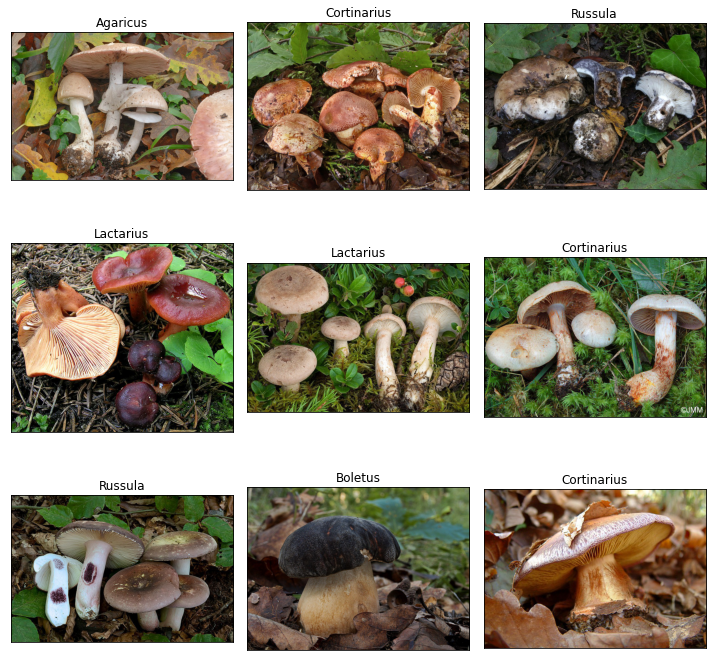

In [7]:
import matplotlib.pyplot as plt
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [8]:
print(f" Count of Rows : {image_df.shape[0]} \n Count of Columns : {image_df.shape[1]} ")

 Count of Rows : 13428 
 Count of Columns : 2 


### Data Preprocessing

In [9]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

In [10]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [11]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 7520 validated image filenames belonging to 9 classes.
Found 1879 validated image filenames belonging to 9 classes.
Found 4029 validated image filenames belonging to 9 classes.


### Training the model

In [12]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [13]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(256, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(256, activation='relu')(x)

outputs = tf.keras.layers.Dense(9, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)


print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [14]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
235/235 [==============================] - 603s 3s/step - loss: 1.0394 - accuracy: 0.6364 - val_loss: 0.8019 - val_accuracy: 0.7270
Epoch 2/100
235/235 [==============================] - 471s 2s/step - loss: 0.5385 - accuracy: 0.8089 - val_loss: 0.6092 - val_accuracy: 0.7983
Epoch 3/100
235/235 [==============================] - 558s 2s/step - loss: 0.3429 - accuracy: 0.8875 - val_loss: 0.5295 - val_accuracy: 0.8345
Epoch 4/100
235/235 [==============================] - 524s 2s/step - loss: 0.2146 - accuracy: 0.9293 - val_loss: 0.5199 - val_accuracy: 0.8430
Epoch 5/100
235/235 [==============================] - 566s 2s/step - loss: 0.1288 - accuracy: 0.9573 - val_loss: 0.4517 - val_accuracy: 0.8792
Epoch 6/100
235/235 [==============================] - 602s 3s/step - loss: 0.0848 - accuracy: 0.9742 - val_loss: 0.6175 - val_accuracy: 0.8467
Epoch 7/100
235/235 [==============================] - 563s 2s/step - loss: 0.0845 - accuracy: 0.9702 - val_loss: 0.5243 - val_accuracy:

### Model Evaluation

In [15]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.44097
Test Accuracy: 88.16%


In [16]:
predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

126/126 [==============================] - 258s 2s/step


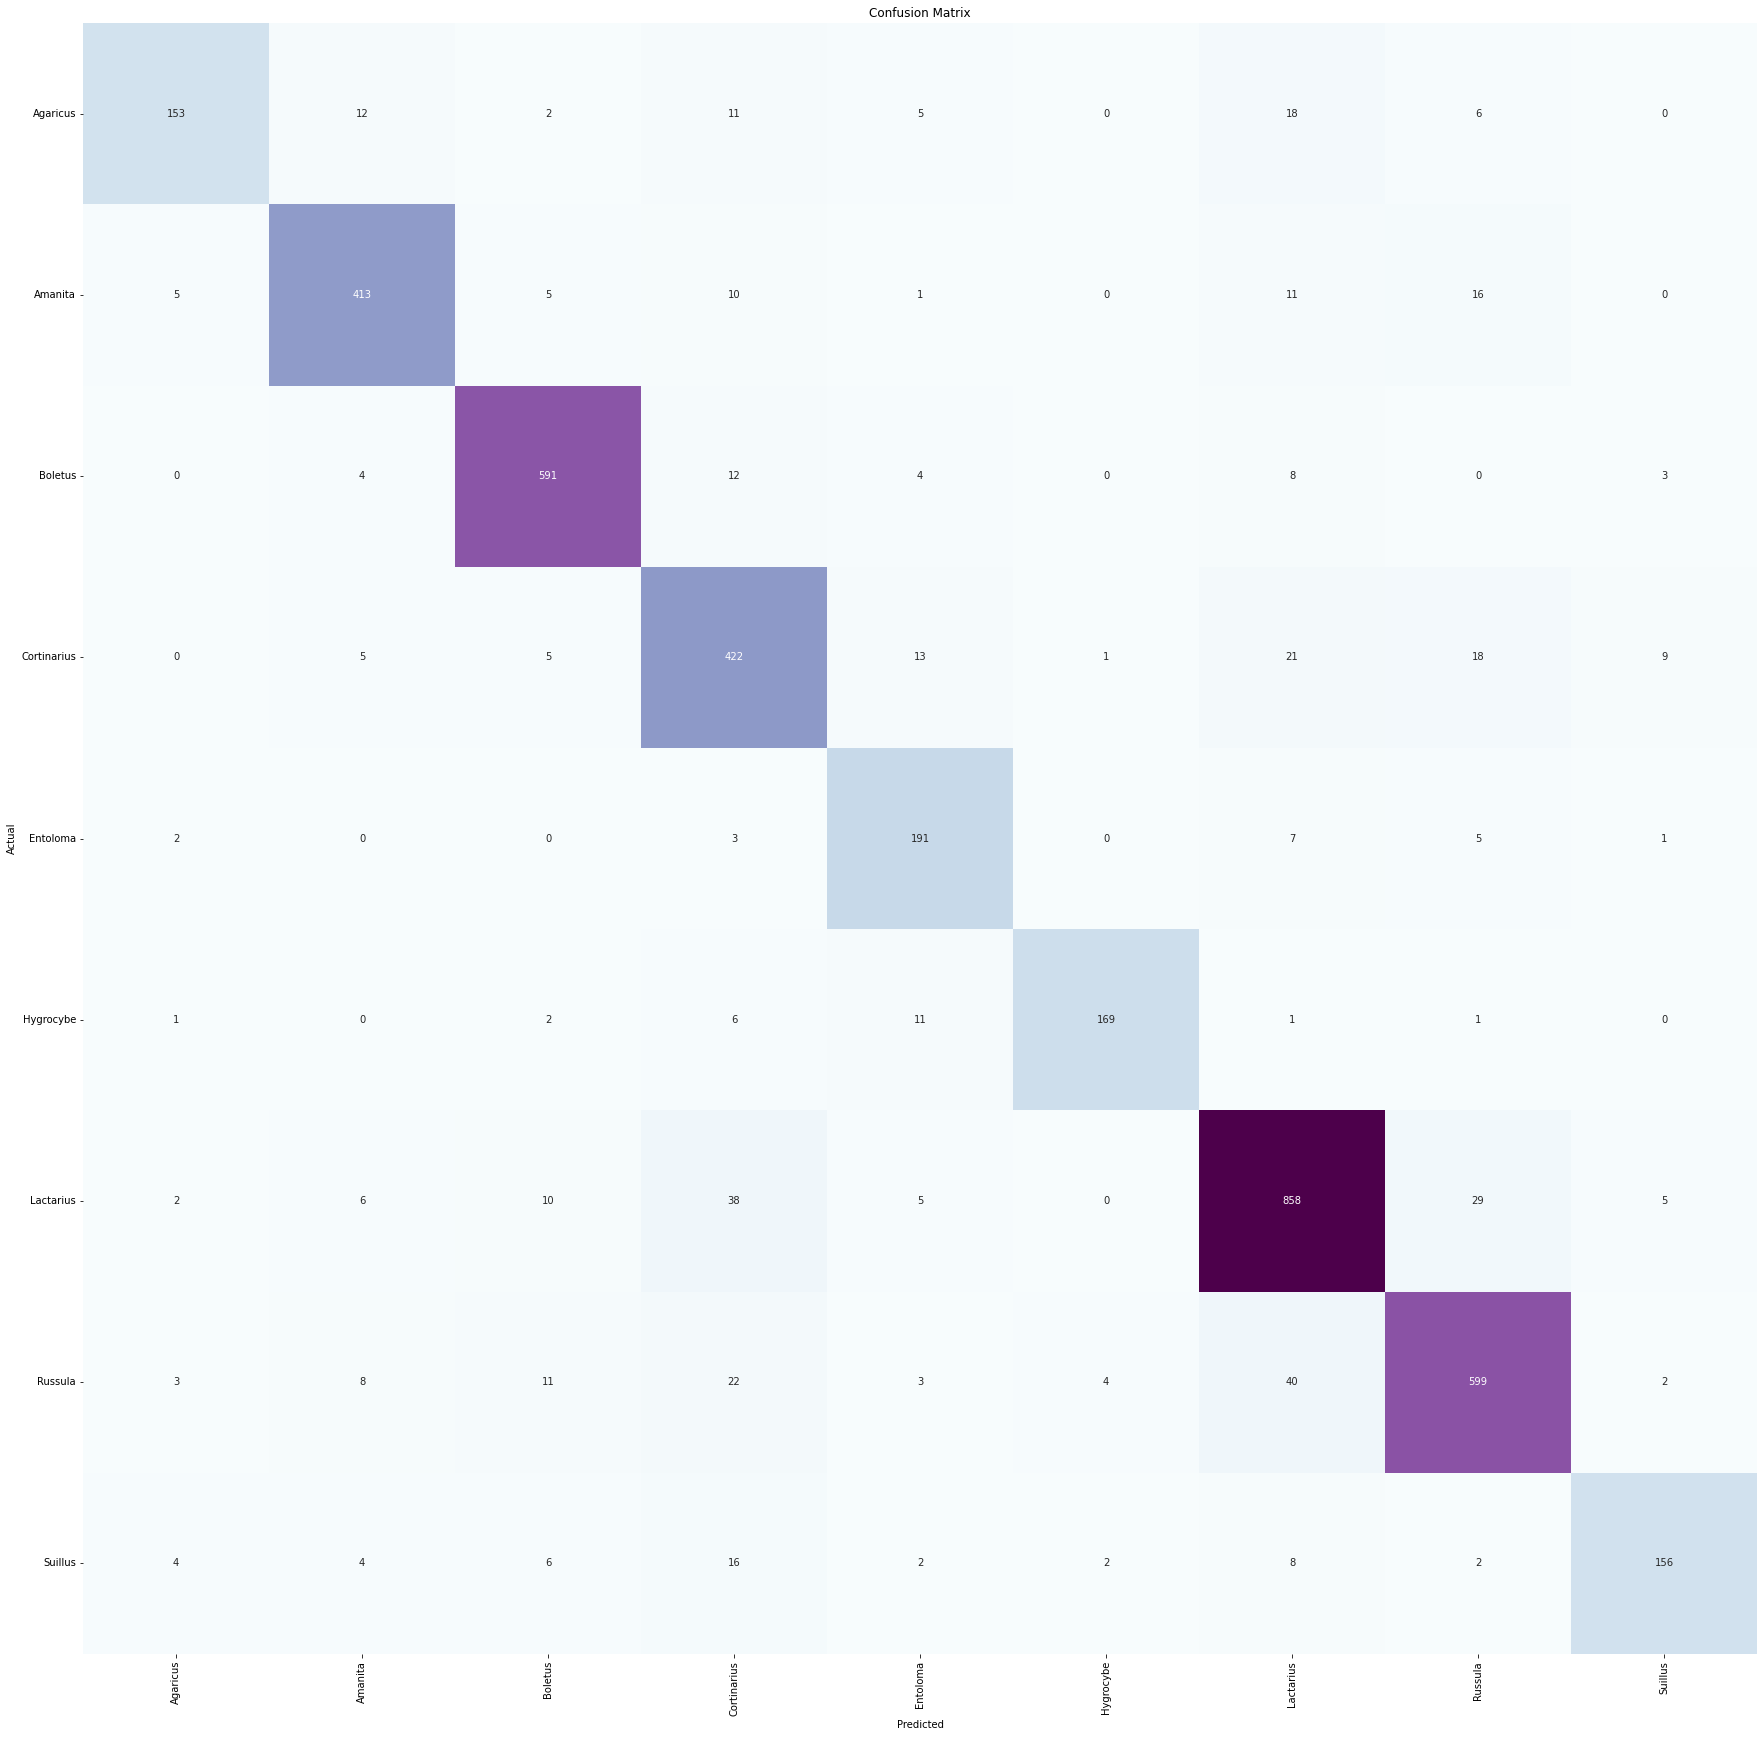

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='BuPu', cbar=False)
plt.xticks(ticks=np.arange(9) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(9) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [18]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
               precision    recall  f1-score   support

    Agaricus       0.90      0.74      0.81       207
     Amanita       0.91      0.90      0.90       461
     Boletus       0.94      0.95      0.94       622
 Cortinarius       0.78      0.85      0.82       494
    Entoloma       0.81      0.91      0.86       209
   Hygrocybe       0.96      0.88      0.92       191
   Lactarius       0.88      0.90      0.89       953
     Russula       0.89      0.87      0.88       692
     Suillus       0.89      0.78      0.83       200

    accuracy                           0.88      4029
   macro avg       0.88      0.86      0.87      4029
weighted avg       0.88      0.88      0.88      4029



### Visualizing loss curves

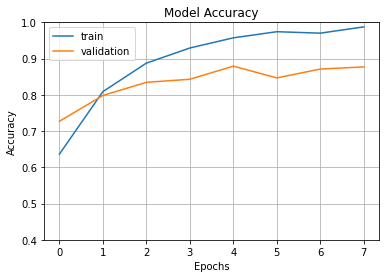

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

### Making predictions on the Test Data

In [20]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)


labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]


print(f'The first 5 predictions: {pred[:5]}')

126/126 [==============================] - 247s 2s/step
The first 5 predictions: ['Hygrocybe', 'Boletus', 'Lactarius', 'Cortinarius', 'Boletus']


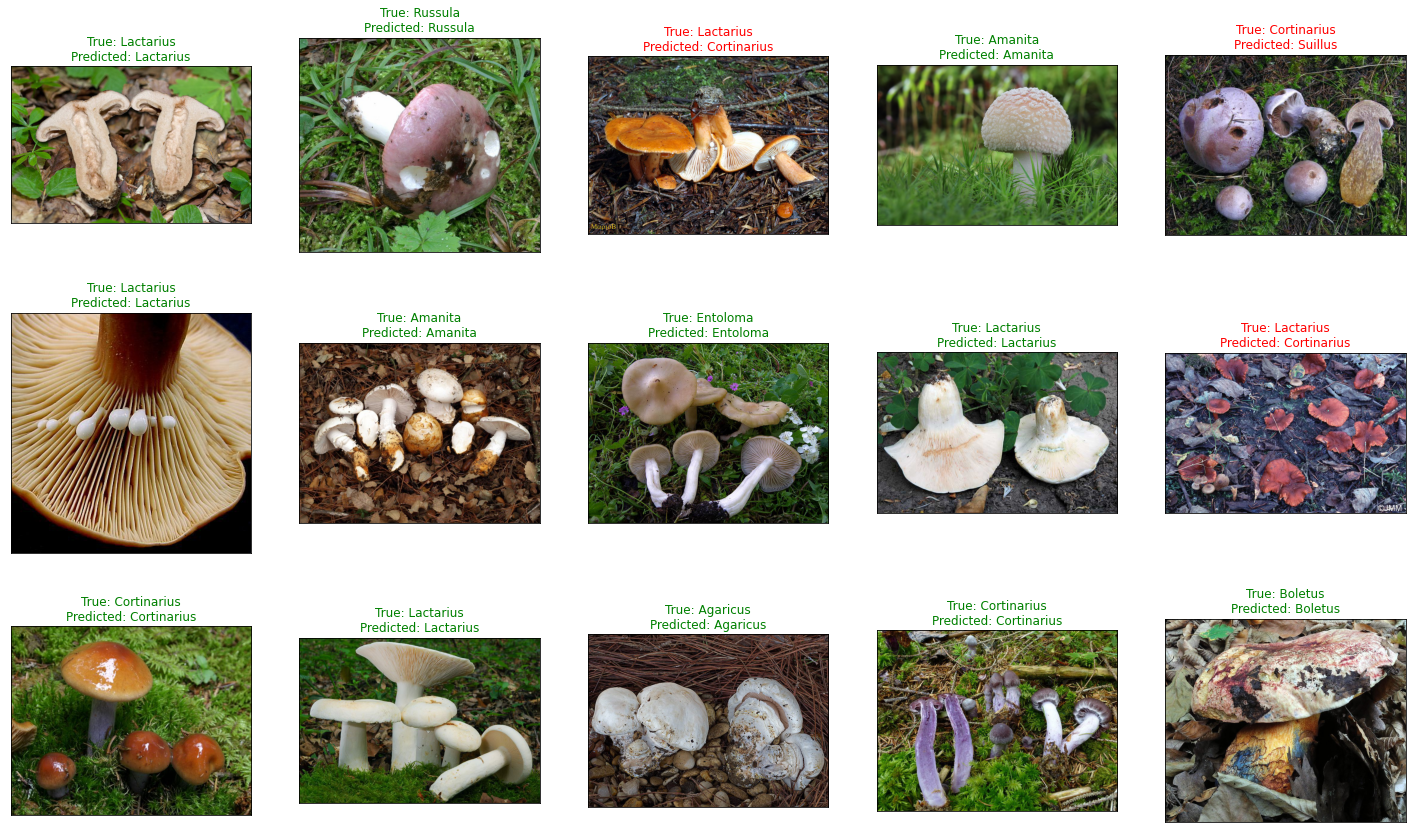

<Figure size 432x288 with 0 Axes>

In [21]:

random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()